In [1]:
# Seek the optimal distribution in latent space

In [290]:
import numpy as np
from scipy.stats import norm
import warnings
import matplotlib.pyplot as plt

def auc(m1, s1, m2, s2):
    ''' Calculate the area under two overlapping Gaussians '''
    
    v1 = s1**2
    v2 = s2**2
    
    d = v1 - v2
    tmp = (m1 - m2)**2 + 2 * d * np.log(s1 / s2)
    n1 = m2 * v1 - s2 * (m1 * s2 + s1 * tmp**.5  )
    n2 = m2 * v1 - s2 * (m1 * s2 - s1 * tmp**.5  )
    
    if np.isclose(s1,s2):
        c = (m1 + m2) / 2.
        c1 = c
        c2 = -c
    else:
        c1 = n1 / d
        c2 = - n2 / d
    if c1 > c2:
        c1, c2 = c2, c1
    #print("c1: ", c1)
    #print("c2: ", c2)
    
    cdf_11 = norm.cdf(c1,m1,s1)
    cdf_22 = norm.cdf(c2,m2,s2)
    cdf_12 = norm.cdf(c1,m2,s2)
    cdf_21 = norm.cdf(c2,m1,s1)
    r = np.minimum(cdf_11, cdf_12) + \
        np.minimum(cdf_21 - cdf_11, cdf_22 - cdf_12) + \
        np.minimum(1. - cdf_21, 1. -cdf_22)

    return r

# print(auc(-0.11931687115428534,1.0,-0.732152020630096,1.0))
# print(auc(1.5,1.0,1,1.))
# print(auc(1.,1.0,-1, 1.))

# def kl_loss(mean1, mean2, log_var1, log_var2):
#     '''KL-divergence between two Gaussian'''
#     return - .5 * (1 + log_var1 - log_var2 - ((np.exp(log_var1) + np.square(mean1 - mean2)) / np.exp(log_var2)))
# 
# 
# def kl_loss_n(mean, log_var):
#     '''KL-divergence between an abitrary Gaussian and the normal distribution'''
#     return kl_loss(mean, 0., log_var, 0.)

def kl_loss_n(mean1, log_var1):
    '''KL-divergence between an abitrary Gaussian and the normal distribution'''
    f_mean = kl_loss_n_mean(mean1)
    f_var = kl_loss_n_log_var(log_var1)
    return f_mean + f_var

def kl_loss_n_mean(mean):
    return 0.5 * np.square(mean)

def kl_loss_n_log_var(log_var):
    #TODO Does the constant in the beginning makes a difference (at least not for gradient decent)
    return - .5 * (1 + log_var - np.exp(log_var))

#mean = 101
#log_var = 10
#print(kl_loss_n(mean, log_var))
#print(test(mean, log_var))

In [291]:
#t = auc(5.28, 0.91 , 8.45  , 1.36) # 0.1584125789543353
t = auc(-1., 1., 1., 1.)
print(t)

0.31731050786291415


In [500]:
import time
from joblib import Parallel, delayed

def losses(mean, var, debug = False, do_parallel = 2, n_jobs = 2):
    n = len(mean)
    l_aucs = np.zeros(shape=(n,n))
    #l_var = np.zeros(shape=(n,))
    #l_mean = np.zeros(shape=(n,))
    
    l_var = kl_loss_n_log_var(np.log(var))
    l_mean = kl_loss_n_mean(mean)
    t = time.time()
    
    def inner_loop(idxr, mean, var):
        '''Inner loop for do_parallel = 2'''
        l_aucs = np.zeros(shape=(n,))
        for idxc in range(idxr + 1,n):
                l_aucs[idxc] = auc(mean[idxr],var[idxr],mean[idxc],var[idxc])
        return l_aucs
    if do_parallel == 0:
        for idxr in range(n):
            for idxc in range(idxr + 1,n):
                l_aucs[idxr, idxc] = auc(mean[idxr],var[idxr],mean[idxc],var[idxc])
    elif do_parallel == 1:
        for idxr in range(n):
            l_aucs[idxr, idxr + 1 : ] = \
                Parallel(n_jobs=n_jobs)(delayed(auc)(mean[idxr],var[idxr],mean[idxc],var[idxc]) for idxc in range(idxr + 1,n))
    elif do_parallel == 2:
        l_aucs = np.asarray( \
            Parallel(n_jobs=n_jobs)(delayed(inner_loop)(idxr, mean, var) for idxr in range(n)))
        
    # for idxr in range(n):
    #     l_var[idxr] = kl_loss_n_log_var(np.log(var[idxr]))
    #     l_mean[idxr] = kl_loss_n_mean(mean[idxr])
    #     for idxc in range(idxr + 1,n):
    #         l_aucs[idxr, idxc] = auc(mean[idxr],var[idxr],mean[idxc],var[idxc])
    #     #    #print(mean[idxr],var[idxr],mean[idxc],var[idxc])
    #     #    #print(aucs[idxr, idxc])
    if debug:
        print("l_aucs time: ", time.time() - t)
    mean_overlap = l_aucs.sum() / (n**2 - n) / 2.
    mean_l_var = l_var.mean()
    mean_l_mean = l_mean.mean()
    mean_l_dkl = (l_var + l_mean).mean()
    
    return mean_overlap, mean_l_var, mean_l_mean, mean_l_dkl

def losses_print(mean, var):
    mean_overlap, mean_l_var, mean_l_mean, mean_l_dkl = losses(mean, var)
    print("Mean overlap: ", mean_overlap)
    print("Mean l_var:   ", mean_l_var)
    print("Mean l_mean:  ", mean_l_mean)
    print("Mean l_dkl:   ", mean_l_dkl)

In [501]:
n = 10
mean = np.random.normal(loc=0.0, scale=1.0, size=n)
var = np.ones(shape=(n,))
losses_print(mean, var)

Mean overlap:  0.17387534356172807
Mean l_var:    0.0
Mean l_mean:   0.3069924723031864
Mean l_dkl:    0.3069924723031864


In [546]:
#mean_overlap, mean_l_var, mean_l_mean, mean_l_dkl = [], [], [], []
results = {"mean_overlap": [], "mean_l_var": [], "mean_l_mean": [], "mean_l_dkl": [], "scale": [], "var": []}
scales = np.arange(0.1, 2., 0.1)
vars = np.arange(0.1, 2., 0.1)
n_scales = len(scales)
n_vars = len(vars)

def store_results(results, mean, _var):
    _mean_overlap, _mean_l_var, _mean_l_mean, _mean_l_dkl = losses(mean, _var)
    results["mean_overlap"].append(_mean_overlap)
    results["mean_l_var"].append(_mean_l_var)
    results["mean_l_mean"].append(_mean_l_mean)
    results["mean_l_dkl"].append(_mean_l_dkl)

for scale, scale_idx in zip(scales, range(n_scales)):
    print("Progress: ", scale_idx, "/", n_scales)
    for var in vars:
        np.random.seed(seed=0)
        mean = np.random.normal(loc=0.0, scale=scale, size=n)
        _var = var * np.ones(shape=(n,))
        store_results(results, mean, _var)
        results["var"].append(var)
        results["scale"].append(scale)

Progress:  0 / 19
Progress:  1 / 19
Progress:  2 / 19
Progress:  3 / 19
Progress:  4 / 19
Progress:  5 / 19
Progress:  6 / 19
Progress:  7 / 19
Progress:  8 / 19
Progress:  9 / 19


KeyboardInterrupt: 

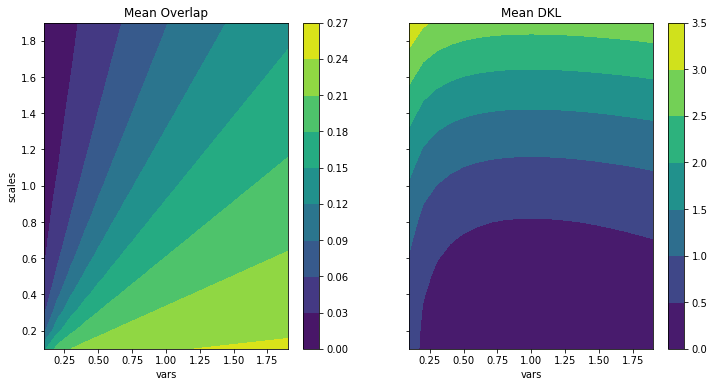

In [503]:
vars_grid, scales_grid = np.meshgrid(vars, scales)

f, ax = plt.subplots(1,2, figsize=(12,6), sharey=True)
h1 = ax[0].contourf(vars_grid,scales_grid,np.asarray(results["mean_overlap"]).reshape((n_scales,n_vars)))
plt.colorbar(h1,ax=ax[0])
h2 = ax[1].contourf(vars_grid,scales_grid,np.asarray(results["mean_l_dkl"]).reshape((n_scales,n_vars)))
plt.colorbar(h2,ax=ax[1])
ax[0].set_xlabel("vars")
ax[1].set_xlabel("vars")
ax[0].set_ylabel("scales")
ax[0].set_title("Mean Overlap")
ax[1].set_title("Mean DKL")
plt.show()

In the upper figures we see the *scales* and *vars* factor.
*scales* is the variance of the Gaussian, from which the mean values are sampled.
*vars* is the variance of the corresponding means.
Therefore, we sample the parameters from a *Bayesian Mixture of Gaussian* (w/o actually sampling from it).

For the *Mean Overlap* plot, we observe expected behaviour:
We observe that the overlap reduces for increasing *scales*, because each of the sampled Gaussian is further away from the other.
For increasing *vars* the overlap increases.

For the *Mean DKL* plot, we observe behaviour similar to the *DKL vs. var* plot:
We observe a DKL optimum around *vars*=1.0.
The DKL increases with increasing *scales*, because the samples are further away from the prio mean (s.t. 0).

var:  1.0
scale:  1.0


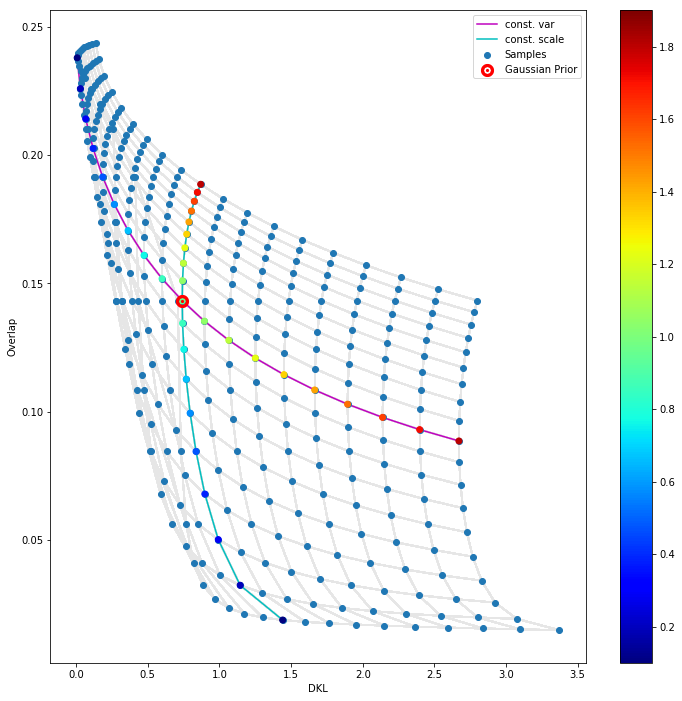

In [504]:

import matplotlib
cmap = matplotlib.cm.get_cmap('jet')
# Cast to numpy
for key in results:
    results[key] = np.asarray(results[key])

_, ax = plt.subplots(1,1, figsize=(12, 12))

def get_mask(var_idx, scale_idx):
    '''Get masks for constant var and scale'''
    var_mask = np.asarray([var == vars[var_idx] for var in results["var"]], dtype=bool)
    scale_mask = np.asarray([scale == scales[scale_idx] for scale in results["scale"]], dtype=bool)
    return var_mask, scale_mask

for var_idx in range(n_vars):
    for scale_idx in range(n_scales):
        var_mask, scale_mask = get_mask(var_idx, scale_idx)
        ax.plot(results["mean_l_dkl"][var_mask], results["mean_overlap"][var_mask], c=[.9, .9, .9, .9], zorder=1)
        ax.plot(results["mean_l_dkl"][scale_mask], results["mean_overlap"][scale_mask], c=[.9, .9, .9, .9], zorder=1)

ax.scatter(results["mean_l_dkl"], results["mean_overlap"], label="Samples", zorder=10)

# Choose var=1 and scale=1
var_idx = 9
scale_idx = 9
print("var: ", vars[var_idx])
print("scale: ", scales[scale_idx])
var_mask, scale_mask = get_mask(var_idx, scale_idx)

# Constant var
ax.plot(results["mean_l_dkl"][var_mask], results["mean_overlap"][var_mask], 'm', label='const. var')
val = results["scale"][var_mask]
rgba = cmap((val - val.min()) / val.max())
ax.scatter(results["mean_l_dkl"][var_mask], results["mean_overlap"][var_mask], c = rgba, zorder=20)

# Constant scale
ax.plot(results["mean_l_dkl"][scale_mask], results["mean_overlap"][scale_mask], 'c', label='const. scale')
val = results["var"][scale_mask]
rgba = cmap((val - val.min()) / val.max())
ax.scatter(results["mean_l_dkl"][scale_mask], results["mean_overlap"][scale_mask], c = rgba, zorder=20) #, edgecolors = None, linewidths = 5, s = 200

# Colorbar
import matplotlib.cm as cm
m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(val)
plt.colorbar(m)

# Standard Gaussian
np.random.seed(seed=0)
mean = np.random.normal(loc=0.0, scale=1., size=n)
_var = np.ones(shape=(n,))
_mean_overlap, _, _, _mean_l_dkl = losses(mean, _var)
plt.scatter(_mean_l_dkl, _mean_overlap, marker='o', s=10, linewidths = 10, c='r', label="Gaussian Prior", zorder=30)

ax.legend()
ax.set_xlabel("DKL")
ax.set_ylabel("Overlap")
plt.show()

- Go on with: is the final distribution, if sampled from all Gausians, again a Gaussian? Central limit theorem?
- What is the optimal distribution?

# Find optimal distribution

In [505]:
from scipy.optimize import minimize # minimize(f, x0, args=(a, b, c))

In [547]:
n = 51
mean = np.linspace(-10, 10, n, True)
var = .5 * np.ones(shape=(n,))
losses_print(mean, var)

# results = {"mean_overlap": [], "mean_l_var": [], "mean_l_mean": [], "mean_l_dkl": [], "scale": [], "var": []}
# scales = np.arange(0.1, 2., 0.1)
# vars = np.arange(0.1, 2., 0.1)
# n_scales = len(scales)
# n_vars = len(vars)
# 
# for scale, scale_idx in zip(scales, range(n_scales)):
#     print("Progress: ", scale_idx, "/", n_scales)
#     for var in vars:
#         np.random.seed(seed=0)
#         mean = np.random.normal(loc=0.0, scale=scale, size=n)
#         _var = var * np.ones(shape=(n,))
#         _mean_overlap, _mean_l_var, _mean_l_mean, _mean_l_dkl = losses(mean, _var)
#         results["mean_overlap"].append(_mean_overlap)
#         results["mean_l_var"].append(_mean_l_var)
#         results["mean_l_mean"].append(_mean_l_mean)
#         results["mean_l_dkl"].append(_mean_l_dkl)
#         results["var"].append(var)
#         results["scale"].append(scale)

def objective(current_mean_var, current_idx, mean, var):
    mean[current_idx] = current_mean_var[0]
    var[current_idx] = current_mean_var[1]
    mean_overlap, _, _, mean_l_dkl = losses(mean, var, debug = False, n_jobs=2, do_parallel=2)
    return mean_overlap + mean_l_dkl

epoch = 30
results = {"mean_overlap": [], "mean_l_var": [], "mean_l_mean": [], "mean_l_dkl": [], "mean": [], "var": [], "idx": [-1]}
store_results(results, mean, var)
results["mean"].append(mean.copy())
results["var"].append(var.copy())
for e in range(epoch):
    print("Progress: ", e, "/", epoch)
    # Optimize the objective
    #_mean_overlap, _mean_l_var, _mean_l_mean, _mean_l_dkl = losses(mean, _var)
    current_idx = np.random.randint(0,n) # choose one of the samples randomly
    mean_var_0 = np.asarray([mean[current_idx], var[current_idx]])
    res = minimize(objective, mean_var_0, args=(current_idx, mean, var), method='Nelder-Mead',
                   tol=None, options = {"maxiter": 2, "disp": False})
    # Copy back
    mean[current_idx] = res.x[0]
    var[current_idx] = res.x[1]
    
    # store evaluation
    results["mean"].append(mean.copy())
    results["var"].append(var.copy())
    results["idx"].append(current_idx)

Mean overlap:  0.014617387814665534
Mean l_var:    0.09657359027997264
Mean l_mean:   17.33333333333334
Mean l_dkl:    17.42990692361331
Progress:  0 / 30
Progress:  1 / 30
Progress:  2 / 30
Progress:  3 / 30
Progress:  4 / 30
Progress:  5 / 30
Progress:  6 / 30
Progress:  7 / 30
Progress:  8 / 30
Progress:  9 / 30
Progress:  10 / 30
Progress:  11 / 30
Progress:  12 / 30
Progress:  13 / 30
Progress:  14 / 30
Progress:  15 / 30
Progress:  16 / 30
Progress:  17 / 30
Progress:  18 / 30
Progress:  19 / 30
Progress:  20 / 30
Progress:  21 / 30
Progress:  22 / 30
Progress:  23 / 30
Progress:  24 / 30
Progress:  25 / 30
Progress:  26 / 30
Progress:  27 / 30
Progress:  28 / 30
Progress:  29 / 30


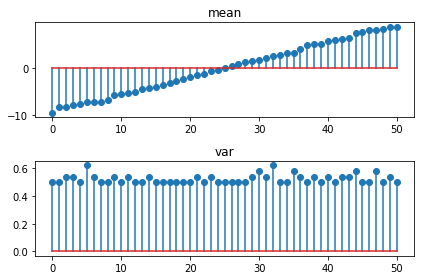

In [548]:
f, ax = plt.subplots(2,1)
sort_order = np.argsort(mean)
ax[0].stem(mean[sort_order])
ax[1].stem(var[sort_order])
ax[0].set_title("mean")
ax[1].set_title("var")
plt.tight_layout()
plt.show()


